In [1]:
import json
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pickle


In [2]:
# Load data from JSON file
with open('job_data.json') as json_file:
    data = json.load(json_file)

Epoch 1/100
3/3 [==============================] - 12s 1s/step - loss: 8.8652 - accuracy: 0.0278 - val_loss: 8.6244 - val_accuracy: 0.1250
Epoch 2/100
3/3 [==============================] - 0s 98ms/step - loss: 8.5553 - accuracy: 0.0833 - val_loss: 8.3264 - val_accuracy: 0.1250
Epoch 3/100
3/3 [==============================] - 0s 175ms/step - loss: 8.2584 - accuracy: 0.1667 - val_loss: 8.0388 - val_accuracy: 0.2500
Epoch 4/100
3/3 [==============================] - 0s 124ms/step - loss: 7.9705 - accuracy: 0.2639 - val_loss: 7.7627 - val_accuracy: 0.1250
Epoch 5/100
3/3 [==============================] - 0s 125ms/step - loss: 7.6922 - accuracy: 0.3750 - val_loss: 7.4965 - val_accuracy: 0.0000e+00
Epoch 6/100
3/3 [==============================] - 0s 61ms/step - loss: 7.4304 - accuracy: 0.2639 - val_loss: 7.2415 - val_accuracy: 0.0000e+00
Epoch 7/100
3/3 [==============================] - 0s 52ms/step - loss: 7.1751 - accuracy: 0.2917 - val_loss: 6.9967 - val_accuracy: 0.0000e+00
Epoch 

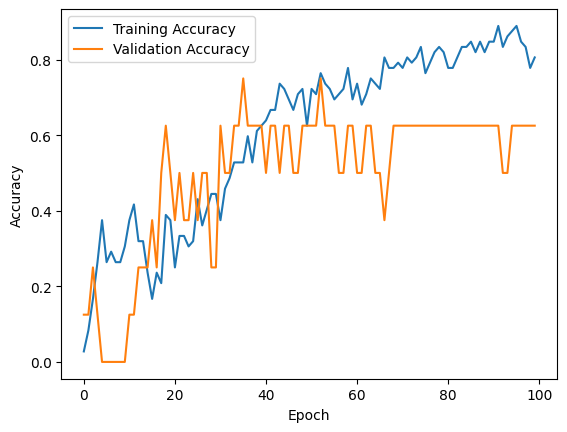

In [3]:
# Extract data from JSON
job_fields = data['job_fields']
X_text = []
y_labels = []

for field in job_fields:
    field_name = field['field_name']
    for job in field['job_examples']:
        skills = ' '.join(job['skills'])  # Only use skills for prediction
        X_text.append(skills)
        y_labels.append(field_name)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)


# Tokenize text data
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_text)
X_encoded = tokenizer.texts_to_sequences(X_text)

# Pad sequences
X_padded = pad_sequences(X_encoded)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.1, random_state=42)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X_padded.shape[1]),
    tf.keras.layers.LSTM(64, dropout=0.3),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(set(y_labels)), activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.1))
])

# Compile the model with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Plot the training graph
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

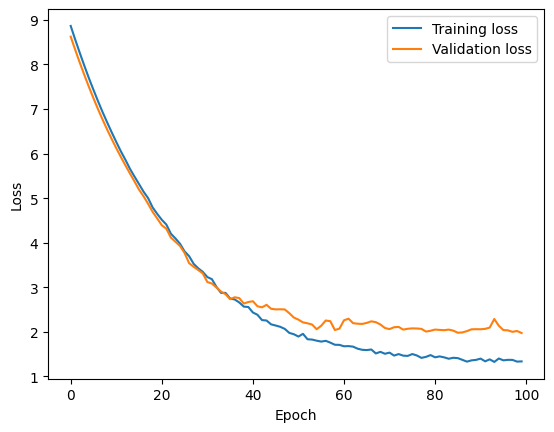

In [4]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [5]:
model.save('my_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
def predict_category_for_skills(model, tokenizer, skills):
    # Tokenize and pad the input skills
    skills_sequence = tokenizer.texts_to_sequences([skills])
    skills_padded = pad_sequences(skills_sequence, maxlen=X_padded.shape[1])

    # Get the predicted probabilities for each class
    predicted_probabilities = model.predict(skills_padded)

    # Get the index of the class with the highest probability
    predicted_class_index = np.argmax(predicted_probabilities, axis=-1)[0]

    # Convert the predicted class index back to the original label
    predicted_class = label_encoder.classes_[predicted_class_index]

    return predicted_class

In [7]:
def get_class_indices(label_encoder):
    class_indices = {class_label: index for index, class_label in enumerate(label_encoder.classes_)}
    return class_indices

# Assuming you have a label_encoder object
class_indices = get_class_indices(label_encoder)

# Print the class indices and labels
for class_label, index in class_indices.items():
    print(f"Class: {class_label}, Index: {index}")


Class: Admin/Customer Service, Index: 0
Class: Education, Index: 1
Class: Engineering, Index: 2
Class: Environmental Science, Index: 3
Class: Finance, Index: 4
Class: Healthcare, Index: 5
Class: Hospitality, Index: 6
Class: Human Resources (HR), Index: 7
Class: Information Technology (IT) and Computer Science, Index: 8
Class: Law, Index: 9
Class: Marketing and Advertising, Index: 10
Class: Science, Index: 11


In [8]:
with open('label_encoder_path.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)


In [9]:
with open('tokenizer_path.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [27]:
# Example usage:
skills_to_predict = "business and management skill"
predicted_category = predict_category_for_skills(model, tokenizer, skills_to_predict)

print(f"Predicted Category for Skills '{skills_to_predict}': {predicted_category}")


1/1 [==============================] - 0s 42ms/step
Predicted Category for Skills 'business and management skill': Finance
